######################################################
## Step 1: Import Libraries and Configure Visuals
######################################################

In [48]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

######################################################
## Step 2: Load Data and Basic Inspection
######################################################

In [47]:
data = pd.read_csv("BRCA.csv")
print("Full Data (Before Dropping Missing Values):")
print(data) 

print("\nShape of the original dataset:", data.shape)
print("\nMissing Values per column:")
print(data.isnull().sum())

# Drop rows with missing values
data = data.dropna()
print("\nData shape after dropping missing values:", data.shape)

print("\nData Info:")
data.info()

Full Data (Before Dropping Missing Values):
       Patient_ID   Age  Gender  Protein1  Protein2  Protein3  Protein4  \
0    TCGA-D8-A1XD  36.0  FEMALE  0.080353   0.42638   0.54715  0.273680   
1    TCGA-EW-A1OX  43.0  FEMALE -0.420320   0.57807   0.61447 -0.031505   
2    TCGA-A8-A079  69.0  FEMALE  0.213980   1.31140  -0.32747 -0.234260   
3    TCGA-D8-A1XR  56.0  FEMALE  0.345090  -0.21147  -0.19304  0.124270   
4    TCGA-BH-A0BF  56.0  FEMALE  0.221550   1.90680   0.52045 -0.311990   
..            ...   ...     ...       ...       ...       ...       ...   
336           NaN   NaN     NaN       NaN       NaN       NaN       NaN   
337           NaN   NaN     NaN       NaN       NaN       NaN       NaN   
338           NaN   NaN     NaN       NaN       NaN       NaN       NaN   
339           NaN   NaN     NaN       NaN       NaN       NaN       NaN   
340           NaN   NaN     NaN       NaN       NaN       NaN       NaN   

    Tumour_Stage                      Histology ER stat

######################################################
## Step 3: Exploratory Data Analysis (EDA)
######################################################


--- EDA Outputs ---

Gender Distribution:
Gender
FEMALE    313
MALE        4
Name: count, dtype: int64


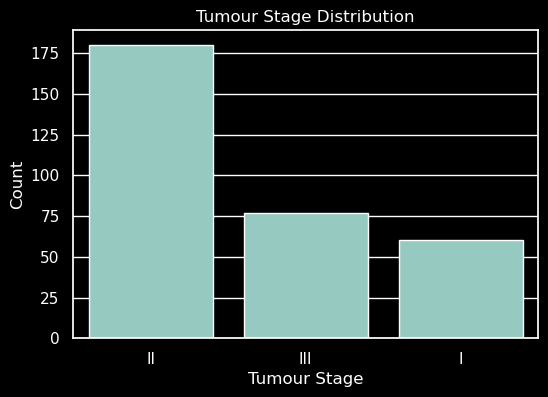

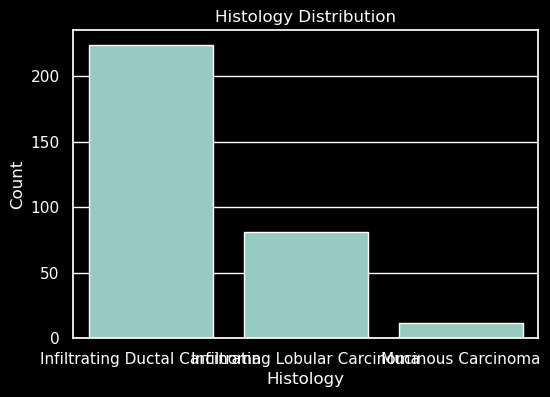

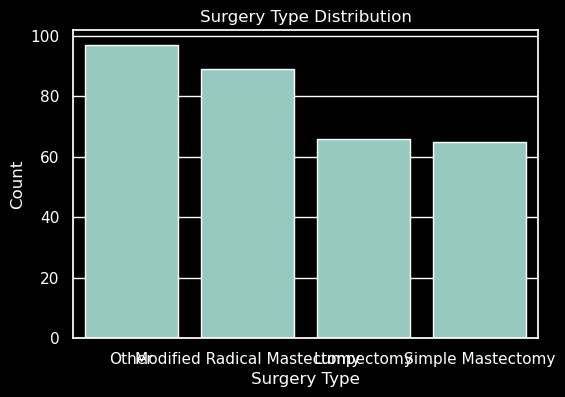

In [52]:
print("\n--- EDA Outputs ---")

# Distribution of Gender
print("\nGender Distribution:")
print(data["Gender"].value_counts())

# Convert columns to consistent case (optional) for plotting
data["Gender"] = data["Gender"].str.upper()  # e.g., "FEMALE"/"MALE"
data["Tumour_Stage"] = data["Tumour_Stage"].str.upper()  # e.g., "I"/"II"/"III"

# Bar chart for Tumour_Stage (sorted high to low)
plt.figure(figsize=(6,4))
stage_counts = data["Tumour_Stage"].value_counts().sort_values(ascending=False)
sns.barplot(x=stage_counts.index, y=stage_counts.values)
plt.title("Tumour Stage Distribution")
plt.xlabel("Tumour Stage")
plt.ylabel("Count")
plt.show()

# Bar chart for Histology (sorted high to low)
plt.figure(figsize=(6,4))
hist_counts = data["Histology"].value_counts().sort_values(ascending=False)
sns.barplot(x=hist_counts.index, y=hist_counts.values)
plt.title("Histology Distribution")
plt.xlabel("Histology")
plt.ylabel("Count")
plt.show()

# Bar chart for Surgery_type (sorted high to low)
plt.figure(figsize=(6,4))
surg_counts = data["Surgery_type"].value_counts().sort_values(ascending=False)
sns.barplot(x=surg_counts.index, y=surg_counts.values)
plt.title("Surgery Type Distribution")
plt.xlabel("Surgery Type")
plt.ylabel("Count")
plt.show()

######################################################
## Step 4: Encode Categorical Columns
######################################################

In [53]:
# Map text categories to numeric
data["Tumour_Stage"] = data["Tumour_Stage"].map({"I": 1, "II": 2, "III": 3})
data["Histology"] = data["Histology"].map({
    "Infiltrating Ductal Carcinoma": 1, 
    "Infiltrating Lobular Carcinoma": 2, 
    "Mucinous Carcinoma": 3
})
data["ER status"] = data["ER status"].map({"Positive": 1})
data["PR status"] = data["PR status"].map({"Positive": 1})
data["HER2 status"] = data["HER2 status"].map({"Positive": 1, "Negative": 2})
data["Gender"] = data["Gender"].map({"MALE": 0, "FEMALE": 1})
data["Surgery_type"] = data["Surgery_type"].map({
    "Other": 1, 
    "Modified Radical Mastectomy": 2, 
    "Lumpectomy": 3, 
    "Simple Mastectomy": 4
})

######################################################
## Step 5: Prepare Features (X) and Target (y)
######################################################

In [54]:
X = data[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 
          'Tumour_Stage', 'Histology', 'ER status', 'PR status', 
          'HER2 status', 'Surgery_type']]
y = data['Patient_Status']

print("\nFeature matrix (X) shape:", X.shape)
print("Target vector (y) length:", len(y))


Feature matrix (X) shape: (317, 12)
Target vector (y) length: 317


######################################################
## Step 6: Train-Test Split
######################################################

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42
)
print("\nSplit data into training (90%) and test (10%) sets.")
print("X_train shape:", X_train.shape, ", y_train length:", len(y_train))
print("X_test shape:", X_test.shape, ", y_test length:", len(y_test))


Split data into training (90%) and test (10%) sets.
X_train shape: (285, 12) , y_train length: 285
X_test shape: (32, 12) , y_test length: 32


######################################################
## Step 7: Address Class Imbalance with SMOTE
######################################################

In [57]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\nSMOTE applied to the training set.")
print("Training set before SMOTE:", X_train.shape)
print("Training set after SMOTE:", X_train_res.shape)


SMOTE applied to the training set.
Training set before SMOTE: (285, 12)
Training set after SMOTE: (458, 12)


######################################################
## Step 8: Define Parameter Grid and GridSearchCV
######################################################

In [58]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

print("\nStarting GridSearchCV with parameters:", param_grid)


Starting GridSearchCV with parameters: {'n_estimators': [50, 100], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5], 'class_weight': [None, 'balanced']}


######################################################
## Step 9: Train the Model with GridSearch
######################################################

In [60]:
grid_search.fit(X_train_res, y_train_res)

print("Grid search complete.")
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score: **{:.2f}**".format(grid_search.best_score_))

best_rf = grid_search.best_estimator_

Grid search complete.
Best Parameters: {'class_weight': None, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best CV Score: **0.83**


######################################################
## Step 10: Evaluate on Test Data
######################################################

In [61]:
test_accuracy = best_rf.score(X_test, y_test)
print("\nTest Accuracy: **{:.2f}**".format(test_accuracy))

y_pred = best_rf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Test Accuracy: **0.72**

Classification Report:
              precision    recall  f1-score   support

       Alive       0.81      0.85      0.83        26
        Dead       0.20      0.17      0.18         6

    accuracy                           0.72        32
   macro avg       0.51      0.51      0.51        32
weighted avg       0.70      0.72      0.71        32

Confusion Matrix:
[[22  4]
 [ 5  1]]
